In [1]:
import os
os.chdir("..")

import torch
import torch.nn as nn
import numpy as np
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import MeanAbsolutePercentageError

from data.dataloader import dl_from_numpy, dataloader_info
from models.predictor import GRU
from utils.utils import load_yaml_config

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_prediction.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset info
dl_info_train = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dataset = dl_info_train['dataset']
seq_length, feature_dim = dataset.window, dataset.feature_dim
batch_size = configs["dataloader"]["batch_size"]
lr = 0.001

# Load data
ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"), batch_size=batch_size)
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)
dl_test = dl_info_test["dataloader"]

In [3]:
# Model training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=100, description=""):
    model.train()
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            for data in dataloader:
                x_train = data[:,:-1,:].float().to(device)
                y_train = data[:,-1:,0].float().to(device)
                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            pbar.set_description(f"{description} loss: {loss.item():.6f}")
    

In [4]:
# Train on original data
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori = nn.L1Loss()
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=2000, description="Original")

Original loss: 0.026594: 100%|██████████| 2000/2000 [00:50<00:00, 39.97it/s]


In [5]:
# Train on synthetic data
model_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_fake = nn.L1Loss()
optimizer_fake = optim.Adam(model_fake.parameters(), lr=lr)
train_model(model_fake, fake_dl, criterion_fake, optimizer_fake, num_epochs=2000, description="Synthetic")

Synthetic loss: 0.027904: 100%|██████████| 2000/2000 [00:49<00:00, 40.43it/s]


In [4]:
ori_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))).to(device)
fake_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"))).to(device)
combined_dataset = torch.concatenate([ori_dataset,fake_dataset])
from torch.utils.data import DataLoader
ori_fake_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# train on original + synthetic data
ori_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))).to(device)
fake_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"))).to(device)
combined_dataset = torch.concatenate([ori_dataset,fake_dataset])
from torch.utils.data import DataLoader
ori_fake_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)

model_ori_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori_fake = nn.L1Loss()
optimizer_ori_fake = optim.Adam(model_ori_fake.parameters(), lr=lr)
train_model(model_ori_fake, ori_fake_dl, criterion_ori_fake, optimizer_ori_fake, num_epochs=2000, description="Synthetic + Original")


Synthetic + Original loss: 0.103341:   7%|▋         | 131/2000 [00:08<01:48, 17.17it/s]

In [7]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
model = model_ori
dataloader = test_loader
model.eval()
criterion = nn.L1Loss()
mapeloss = MeanAbsolutePercentageError().to(device)
total_loss = 0
predictions, true_vals = [], []
with torch.no_grad():
    for data, mean, std in dataloader:
        x_test = data[:, :(seq_length - 1), :].float().to(device)
        y_test = data[:, (seq_length - 1) :, :1].float().to(device)
        mean = mean[:, :, :1].float().to(device)
        std = std[:, :, :1].float().to(device)
        y_pred = model(x_test).view(-1,1,1)
        
        total_loss += criterion(y_pred, y_test) * len(data)

        y_test_unnorm = y_test * std + mean
        y_pred_unnorm = y_pred * std + mean

        predictions.append(y_pred_unnorm.cpu().numpy())
        true_vals.append(y_test_unnorm.cpu().numpy())

total_loss /= len(dataloader.dataset)
predictions = np.concatenate(predictions)
true_vals = np.concatenate(true_vals)
mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()

In [9]:
# Evaluate models on the test dataset
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.L1Loss()
    criterion2 = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    total_loss_L1 = 0
    total_loss_MSE = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        for data, mean, std in dataloader:
            x_test = data[:, :(seq_length - 1), :].float().to(device)
            y_test = data[:, (seq_length - 1) :, :1].float().to(device)
            mean = mean[:, :, :1].float().to(device)
            std = std[:, :, :1].float().to(device)
            y_pred = model(x_test).view(-1,1,1)
            
            total_loss_L1 += criterion(y_pred, y_test) * len(data)
            total_loss_MSE += criterion2(y_pred, y_test) * len(data)

            y_test_unnorm = y_test * std + mean
            y_pred_unnorm = y_pred * std + mean

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    total_loss_L1 /= len(dataloader.dataset)
    total_loss_MSE /= len(dataloader.dataset)
    predictions = np.concatenate(predictions).squeeze()
    true_vals = np.concatenate(true_vals).squeeze()
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_loss_L1, total_loss_MSE, mape_loss, predictions, true_vals

In [10]:
loss_ori_l1, loss_ori_l2, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)

print(f"Original Model : \t L1 loss: {loss_ori_l1:0.5f} \t L2 Loss : {loss_ori_l2:0.5f} \t MAPE loss : {mape_loss_ori:0.5f} ")
print(f"Fake Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
print(f"OriFake Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")


Original Model : 	 L1 loss: 0.61758 	 L2 Loss : 0.70949 	 MAPE loss : 0.01716 
Fake Model : 	 L1 loss: 1.87298 	 L2 Loss : 4.64770 	 MAPE loss : 0.05597 
OriFake Model : 	 L1 loss: 0.67879 	 L2 Loss : 0.83754 	 MAPE loss : 0.01933 


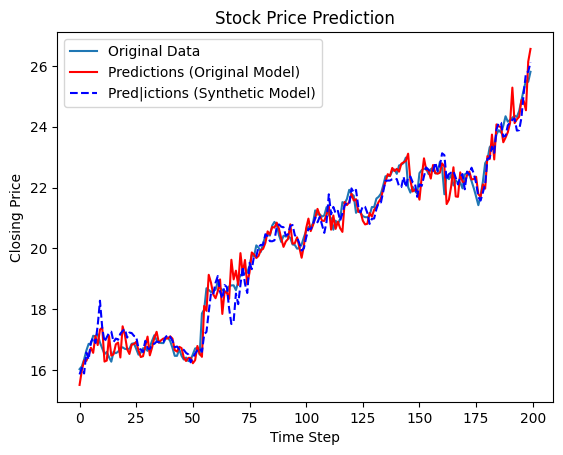

In [11]:
# Visualize predictions
plt.figure()
plt.plot(true_y[:200], label='Original Data')
plt.plot(pred_y_ori[:200], label='Predictions (Original Model)', linestyle='-', color='r')
plt.plot(pred_y_ori_fake[:200], label='Pred|ictions (Synthetic Model)', linestyle='--', color='b')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Closing Price")
plt.show()
